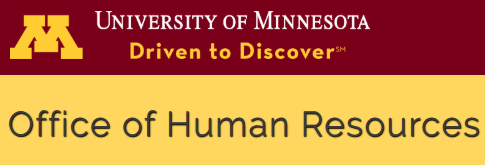

# <span style="color:#ffcc33">This notebook contains analyses that were generated for the Office of Human Resources (henceforth known as OHR) Experiential Learning Project for the University of Minnesota's MSBA 6515 Summer 2020 course.</span>
    
# <span style="color:#ffcc33">The analyses were created using data provided by OHR and ONLY data provided by OHR.  This notebook is not for public consumption and should not be used in any other context than to review the code and the visualizations that were generated for the capstone project.

# <span style="color:#ffcc33">Please do not reproduce or republish this code without written consent of the authors below.</span>

- <b>Course</b>: <i>MSBA 6515 - Capstone Project in Analytics</i>
- <b>Semester</b>: <i>Summer 2020</i>
- <b>CAL Team</b>: <i># 1</i>
- <b>Authors</b>: 
<br><i>Danny Moncada, MSBA 2020 - Data Engineer</i>
<br><i>Claire Ryan, MSBA 2020 - Data Engineer</i>

# <span style="color:#ffcc33">OHR Table Generation & Feature Engineering</span>

- Start with Python kernel
- Load the appropriate libraries
- Load the data (files)
- Subset on the employee population of interest
- Calculate salary, median pay, feature list

In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## System env
import sys

## Data Cleaning
import pandas as pd
import numpy as np

## For Date Time Manipulation
from datetime import datetime, timedelta
import datetime as dt
from dateutil.parser import parse

## For garbage collection
import gc

In [3]:
## Show the Python environment details
print("Here are the environment details...")
print()
print(sys.executable)
print(sys.version)
print(sys.version_info)

## Show the different versions for each library used in the Python exploration
print()
print("This notebook is using pandas version: {}.".format(pd.__version__))
print("This notebook is using numpy version: {}.".format(np.__version__))

Here are the environment details...

C:\Python\envs\ohr_2020\python.exe
3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

This notebook is using pandas version: 0.25.3.
This notebook is using numpy version: 1.18.5.


In [4]:
## Remove some warnings for pandas - they clutter the notebook
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning, DeprecationWarning])

import warnings
warnings.filterwarnings("ignore")

In [5]:
## Find and load the data files first

team_folder = "D:/UMN OHR Data/"

## Employee Dimension
d_um_emp = "D_UM_EMP_06022020.csv"

## HR Dept Hierarchy Dimension
d_hr_org = "D_HR_ORG_06022020.csv"

## HR Common Person Dimension
d_hr_cmm_pers = "D_HR_CMM_PERS_06022020.csv"

## Fact - Additional Pay
#f_addl_pay = "F_EMP_ADDL_PAY_06022020.csv"

## Fact - Components of Pay
f_emp_cmpnt_pay = "F_EMP_CMPNT_PAY_06022020.csv"

## Fact - Headcount & FTE
f_emp_hc_fte = "F_EMP_HC_FTE_06022020.csv"

# <span style="color:#ffcc33">I. Data Loading & Pre-Processing</span>

- Assign prediction date
- Assign target date
- Load Employee Dimension, Headcount & FTE Fact, Institutional Base Salary Fact

## *** Set the Prediction Date Here! ***

In [6]:
## Set a variable for the prediction date (the point in time we are making predictions for)

prediction_date = dt.datetime(2019, 4, 1) #Format: year, month, day

## *** Set the Target Date Here! ***

In [7]:
#### Set a variable for the target date (the point in the future we are making predictions for)

target_date = pd.to_datetime(prediction_date) + timedelta(days = 61) # Two months - Staff
# target_date = pd.to_datetime(prediction_date) + timedelta(days = 183) # Six months - Faculty

In [8]:
## Confirm variables are setting correct prediction start and end dates

print("The prediction start date is: {}".format(prediction_date))
print()
print("The target end date is: {}".format(target_date))

The prediction start date is: 2019-04-01 00:00:00

The target end date is: 2019-06-01 00:00:00


## Columns to pull out of Employee Dimension

- Pull all the columns from the Employee Dimension
- Use what is needed from historical rows to perform calculations
- Ensure no duplicates are occuring on the merges (using LEFT)
- Check on every step by confirming the shape of the dataframe after the merge

In [9]:
## Load in the employee dimension table
## We use low_memory = False because it is mixed data types

d_um_emp_df = pd.read_csv(team_folder + d_um_emp, low_memory = False)

## 1.  Convert Dates and Fix Century Conversion Issue

- Select the Date columns needed for conversion and for use in feature engineering
- Use function so that any date over fifteen years in future will get reduced by 100 years to fix conversion issue
- Replace the columns after calling the function

In [10]:
## Convert date columns to correct format

date_cols = ['EFF_DT', 'ORIG_HIRE_DT', 'UNIV_STRT_DT', 'POS_ENTR_DT', 'LST_INCR_DT', 'LST_WRK_DT', 'WKFC_ACTN_DT', 'JOB_CD_STRT_DT', 'DEPT_ENTR_DT']

d_um_emp_df[date_cols] = d_um_emp_df[date_cols].apply(pd.to_datetime, format = "%d-%b-%y")

In [11]:
## Function for use on any of the date fields to fix parsing error

def convert_date_fields(df, columns):
    
    for i in columns:
        df.loc[df[i] > datetime.strptime("08/29/2035", "%m/%d/%Y"), str(i)] = df[i] - pd.offsets.DateOffset(years = 100)
        
    return df

In [12]:
## Call the function and replace the dataframe fixing the century problems we were noticing

d_um_emp_df = convert_date_fields(d_um_emp_df, date_cols)

## 2.  Load HR Common Person Table for subsetting on University Termination Date

- Load in data from HR Common Person table to get University Termination Date
- To pull out employees who have left the University entirely by using UNIV_TRM_DT
- Join employee table on EMPLID

In [13]:
## Load the HR Common Person table

d_hr_cmm_pers_df = pd.read_csv(team_folder + d_hr_cmm_pers, encoding = "ISO-8859-1")

In [14]:
## We can't use != '' because it's not technically a blank string
## Use isnull and not equal to filter the right emplids

univ_terms = d_hr_cmm_pers_df[~d_hr_cmm_pers_df['UNIV_TRMN_DT'].isnull()]

In [15]:
## Confirm no blank values

univ_terms["UNIV_TRMN_DT"].isnull().value_counts()

False    68004
Name: UNIV_TRMN_DT, dtype: int64

In [16]:
## Convert University Termination Date to DateTime for later use

univ_terms["UNIV_TRMN_DT"] = pd.to_datetime(univ_terms['UNIV_TRMN_DT'])

In [17]:
## Subset the data frame to what we need for merging

univ_terms = univ_terms[["EMPLID", "UNIV_TRMN_DT"]]

## 3.  Load Headcount and FTE Fact Table, filter to .75 FTE

- Load in Headcount and FTE fact to get FTE data required for filtering employees
- One important note: Emplid should not be considered a numeric value!  It is an identifier - make sure when loading it that it is `dtype = str`

In [18]:
## Pull one row per employee based on their Maximum Emp Eff Date
## Load the fact table

f_emp_hc_fte_df = pd.read_csv(team_folder + f_emp_hc_fte, dtype = {"EMPLID": "str"})

In [19]:
## We use FTE_CNT because we want ALL JOBS FTE Count (for employees with mulitple positions)
## Overwriting the fact table variable with just columns needed
f_emp_hc_fte_df = f_emp_hc_fte_df[["EMPLID", "UM_EMP_SID", "UM_EMP_NK_SID", "EMP_EFF_DT", "EMP_EFF_EXPIR_DT", "FTE_CNT"]]

## Convert Effective Date to DateTime for the boolean
f_emp_hc_fte_df["EMP_EFF_DT"] = pd.to_datetime(f_emp_hc_fte_df["EMP_EFF_DT"])

## Convert to max datetime - after running into problems converting this - F#%* datetime!
f_emp_hc_fte_df.loc[f_emp_hc_fte_df["EMP_EFF_EXPIR_DT"] == '12/31/9999', "EMP_EFF_EXPIR_DT"] = pd.Timestamp.max

## Convert Emp Effective Expiration Date to DateTime for the boolean
f_emp_hc_fte_df["EMP_EFF_EXPIR_DT"] = pd.to_datetime(f_emp_hc_fte_df["EMP_EFF_EXPIR_DT"])

In [20]:
## Set up a double boolean condition to filter on 

f_hc_fte_current_row = (f_emp_hc_fte_df["EMP_EFF_DT"] <= prediction_date) & (f_emp_hc_fte_df["EMP_EFF_EXPIR_DT"] >= prediction_date)

## Filter on the Effective Date and Expiration Date

f_emp_hc_fte_df_current = f_emp_hc_fte_df[f_hc_fte_current_row]

## 4. Create the first dataframe containing the employee population who were active on prediction start date.

- Convert Emp Effective Date & Expiration Date to DateTime
- Set max value of Emp Expiration Date to Timestamp max (because 12/31/9999 doesn't exist)
- Convert remaining Emp Expiration Dates to DateTime
- Join the Headcount Fact & FTE with the Employee Dimension subset to ensure those employees were "Active" on prediction date

In [21]:
## Create a dataframe with the employee rows that were active ON the prediction date

employees_cutoff_df = pd.merge(f_emp_hc_fte_df_current, d_um_emp_df, how = "inner", on = ["UM_EMP_SID"], suffixes = ('', '_y'))
employees_cutoff_df.drop(employees_cutoff_df.filter(regex = '_y$').columns.tolist(),axis = 1, inplace = True)

In [22]:
## Print the len of the dataframe prior to filtering

employees_cutoff_df.shape

(131385, 152)

- <i>Employee Status Codes</i>: A, L, P, W
- <i>Job Code Groups</i>: Academic Adminstrative, Academic Professional, Civil Service, Faculty, Labor Represented
- <i>Paygroups</i>: P12, P10, P09
- <i>Employee Payment Type Description</i>: Salaried, Exception Hourly
- <i>Workforce Action Reason</i>: Resignation

In [23]:
## Filter on A - Active, L - Leave of Absence, P - Leave With Pay, W - Short Work Break
## Removes D - Deceased, S - Suspended, R - Retired, T - Terminated
emp_sts_cds = ["A", "L", "P", "W"]

## Job Groups, Paygroups, Payment types
jobcd_grp_codes = ["AA", "AP", "CS", "FA", "LR"]
paygroups = ["P12", "P10", "P09"]
payment_types = ["Salaried", "Exception Hourly"]

#### Employee Cutoff  ####
## Filter the cutoff dataframe
## Do this sequentially to keep it in order
employees_cutoff_df = employees_cutoff_df[employees_cutoff_df["EMP_STS_CD"].isin(emp_sts_cds)]
employees_cutoff_df = employees_cutoff_df[employees_cutoff_df["JOBCD_GRP_CD"].isin(jobcd_grp_codes)]
employees_cutoff_df = employees_cutoff_df[employees_cutoff_df["PAY_GRP_CD"].isin(paygroups)]
employees_cutoff_df = employees_cutoff_df[employees_cutoff_df["EMP_PYMNT_TP_DESC"].isin(payment_types)]
employees_cutoff_df = employees_cutoff_df[employees_cutoff_df['FTE_CNT']>=0.75]

In [24]:
## Should equal 17032

employees_cutoff_df.shape

(17032, 152)

## 5. Create the second DataFrame using similar criteria as the first, EXCEPT we want to see which employees are *still* active on the target date

- We have the Fact loaded already, so we just re-purpose it to get the target date
- Join again with the employee dimension to get those employees who were still active after six month window

In [25]:
## Set up a double boolean condition to filter on the TARGET date
f_hc_fte_target_row = (f_emp_hc_fte_df["EMP_EFF_DT"] <= target_date) & (f_emp_hc_fte_df["EMP_EFF_EXPIR_DT"] >= target_date)

## Filter on the Effective Date and Expiration Date for the target table
f_emp_hc_fte_df_target = f_emp_hc_fte_df[f_hc_fte_target_row]

In [26]:
## Now find all the employees who were still Active on the last day of the window

employees_target_df = pd.merge(f_emp_hc_fte_df_target, d_um_emp_df, how = "inner", on = ["UM_EMP_SID"], suffixes=('', '_y'))
employees_target_df.drop(employees_target_df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [27]:
## Filter the target dataframe
## Don't filter on STATUS CODES!  Remember, we want to see who made it through the life time of the employees
## We will mark the emplids who 'Resigned' and that's our target

employees_target_df = employees_target_df[employees_target_df["JOBCD_GRP_CD"].isin(jobcd_grp_codes)]
employees_target_df = employees_target_df[employees_target_df["PAY_GRP_CD"].isin(paygroups)]
employees_target_df = employees_target_df[employees_target_df["EMP_PYMNT_TP_DESC"].isin(payment_types)]
employees_target_df = employees_target_df[employees_target_df['FTE_CNT']>=0.75]

# <span style="color:#ffcc33">II. Flatten the Data Set</span>

- Now we have two dataframes - one with the population who existed on the prediction date, and another set of employees who existed on the target date
- We `merge` the two datasets together using the Natural Keys - this is important!
- We drop the duplicate columns between the two sets
- We can still count their number of jobs, get their full salary, etc using the `emp_pop_history_df` which we will load later

In [28]:
## Merge the two data frames together to get an all encompassing list of the employees who existed in the prediction start and target end dates

emp_pop_current_df = pd.merge(employees_cutoff_df, employees_target_df, how = "inner", on = ["UM_EMP_NK_SID"], suffixes = ('_x', ''))
emp_pop_current_df.drop(emp_pop_current_df.filter(regex = '_x$').columns.tolist(),axis = 1, inplace = True)

In [29]:
## Add in the termination to the status codes
add_term_code = emp_sts_cds + ['T']
## Find employees with Resignation action reason
action_reasons = ["Resignation"]

emp_pop_current_df = emp_pop_current_df[emp_pop_current_df["EMP_STS_CD"].isin(add_term_code)]

## Add in the University Termination Date to ensure employees churned
emp_pop_current_df = emp_pop_current_df.merge(univ_terms, how = "left", on = ["EMPLID"])

## Find those employees that have a Workforce Action Reason Code of Resignation and make them our Target!
emp_pop_current_df["TARGET"] = np.where((emp_pop_current_df["WKFC_ACTN_RSN_LD"] == 'Resignation'), 1, 0)

## Remove all other Termination Rows that are NOT Resignation as a final clean up
emp_pop_current_df = emp_pop_current_df.drop(emp_pop_current_df[(emp_pop_current_df["TARGET"] == 0) & (emp_pop_current_df["EMP_STS_CD"] == 'T')].index)

In [30]:
## Remove duplicate rows from dataframe, to ensure one row per emplid

dups = emp_pop_current_df.groupby(["EMPLID"])["EMP_REC_NBR"].nunique().reset_index(name = "N")
dups = dups[dups["N"] > 1]

## Reassign this back to original df
emp_pop_current_df = emp_pop_current_df[~emp_pop_current_df["EMPLID"].isin(dups["EMPLID"])]

In [31]:
## Get counts of Targets to determine churn rates
active_emps = emp_pop_current_df[emp_pop_current_df.TARGET == 0].EMPLID.nunique()
churned_emps = emp_pop_current_df[emp_pop_current_df.TARGET == 1].EMPLID.nunique()

print("The active employee count is roughly: {}".format(active_emps))
print()
print("The churned employee count is around: {}".format(churned_emps))
print()
print("This means that your churn rate from start date to end date is {}".format(churned_emps/active_emps*100))

The active employee count is roughly: 16537

The churned employee count is around: 242

This means that your churn rate from start date to end date is 1.4633851363608876


## 7.  Get all of the history from the Employee dimension for this population

- Filter the Employee dimension for just the Job Code Group Code, Paygroups, Action Reason, Payment Types OHR would like to report on
- Filter on the data prior to prediction date

In [32]:
## CHANGING DANNY'S FILTER FUNCTION ABOVE ##
## adding date input to get a data set based on a particular time point

def filter_employee_dim(date=prediction_date, df=d_um_emp_df):
    
    '''
    Grabs filtered data for specified prediction period. 
    
    Inputs: 
        df: employee data frame 
        df2: University terminations data frame 
        date: prediction date, in datetime object format. Data will be filtered to any actions occuring before this date, 
            and will pull resignations within the 8 weeks after this date as the target variable. 
            
    Outputs: tuple of three data frames.
        -filtered historical data frame
    '''
        
    ## Attributes to filter - these can be changed here
    jobcd_grp_codes = ["AA", "AP", "CS", "FA", "LR"]
    paygroups = ["P12", "P10", "P09"]
    payment_types = ["Salaried", "Exception Hourly"]
    
    #### HISTORICAL DATA FRAME ####
    ## Filter the dataframe
    df_filtered = df[df["JOBCD_GRP_CD"].isin(jobcd_grp_codes)]
    df_filtered = df_filtered[df_filtered["PAY_GRP_CD"].isin(paygroups)]
    df_filtered = df_filtered[df_filtered["EMP_PYMNT_TP_DESC"].isin(payment_types)]
    
    ## Filter out actions that occurred after prediction date
    df_filtered = df_filtered[df_filtered["EFF_DT"] <= date]
    
    return df_filtered

In [33]:
## Only pull out the rows needed from the employee dimension
## Using the history prior to prediction date, not target date!

emp_pop_history_df = filter_employee_dim(prediction_date)

## 8.  Load Institutional Base Salary Fact

- Pull in salary information for each emplid
- Filter on BASE, HOURLY, AAA, FAA, INCR, REGENT
    - *AAA* - Administrative Augmentation
    - *BASE* - Base
    - *FAA* - Faculty Augmentation
    - *HOURLY* - Hourly
    - *INCR* - Increment
    - *REGENT* - Regents' Professorship Pay<br><br>
- Faculty get paid in these codes: AAA, FAA, INCR, REGENT, BASE
- *One important note: Emplid should not be considered a numeric value!  It is an identifier - make sure when loading it that it is `dtype = str`*

In [35]:
## Pull in the Pay Component dataframe
## Only include the fields that are needed

f_emp_cmpnt_pay_df = pd.read_csv(team_folder + f_emp_cmpnt_pay, low_memory = False, dtype = {"EMPLID": "str"})

## Because of the way the Fact is structured, we want to get the most current row for each emplid
## We can use a BETWEEN clause on the Emp Effective Date and Emp Effective Expiration Date

f_emp_cmpnt_pay_df = f_emp_cmpnt_pay_df[["UM_EMP_SID", "UM_EMP_NK_SID", "EMPLID", "EMP_EFF_DT", "EMP_EFF_EXPIR_DT", "PAY_CMPNT_CD", "PAY_CMPNT_SD", "PAY_CMPNT_RT"]]

In [36]:
## Create a list of valid component codes
ibs_components = ["HRLY", "BASE", "AAA", "FAA", "INCR", "REGENT"]

## Filter the fact table to the pay components that are used in Institutional Base Salary
f_emp_cmpnt_pay_df = f_emp_cmpnt_pay_df[f_emp_cmpnt_pay_df["PAY_CMPNT_CD"].isin(ibs_components)]

In [37]:
## Convert to datetime stamp - the conversion is still lengthy
f_emp_cmpnt_pay_df["EMP_EFF_DT"] = f_emp_cmpnt_pay_df["EMP_EFF_DT"].apply(pd.to_datetime, format = "%m/%d/%Y")

## Convert to max datetime - after running into problems converting this - F#%* datetime!
f_emp_cmpnt_pay_df.loc[f_emp_cmpnt_pay_df["EMP_EFF_EXPIR_DT"] == '12/31/9999', "EMP_EFF_EXPIR_DT"] = pd.Timestamp.max

## Convert Emp Effective Expiration Date to DateTime for the boolean
f_emp_cmpnt_pay_df["EMP_EFF_EXPIR_DT"] = pd.to_datetime(f_emp_cmpnt_pay_df["EMP_EFF_EXPIR_DT"])

## Set up a double boolean condition to filter on 
f_emp_pay_current_row = (f_emp_cmpnt_pay_df["EMP_EFF_DT"] <= prediction_date) & (f_emp_cmpnt_pay_df["EMP_EFF_EXPIR_DT"] >= prediction_date)

## Grab the most current row for every emplid
f_emp_cmpnt_pay_df = f_emp_cmpnt_pay_df[f_emp_pay_current_row]

# <span style="color:#ffcc33">III. Data Transformation and Feature Engineering.</span> 

## Category 1: How Much an Employee Gets Paid

- A. Salary (float)
- B. Number of Raises (float)
- C. Pay Above Median Indicator (1/0)

### A. Salary

- We locate every employee's full salary (*AT THE TIME OF PREDICTION*) across all of their jobs attributed to every row in our flattened data
- If the employee does not have an PAY_CMPNT_RT, use their ANNL_RT_AMNT so we don't have any zeros.

In [38]:
## Merge the salary information at the time of prediction
employees_salary_cutoff = pd.merge(f_emp_cmpnt_pay_df, d_um_emp_df, how = "inner", on = ["UM_EMP_SID"], suffixes = ('', '_y'))
## Remove all the duplicate rows from merging the two tables
employees_salary_cutoff.drop(employees_salary_cutoff.filter(regex = '_y$').columns.tolist(),axis = 1, inplace = True)

## Create a variable for PAY that will be used for many features down the lin
employees_salary_cutoff["PAY"] = np.where(employees_salary_cutoff["PAY_CMPNT_CD"] == "HRLY",
                                        employees_salary_cutoff["PAY_CMPNT_RT"] * employees_salary_cutoff["HR_PER_YR"],
                                          employees_salary_cutoff["PAY_CMPNT_RT"])
##
holistic_salaries = employees_salary_cutoff.groupby('EMPLID').PAY.sum().reset_index()

In [39]:
## Grab the salaries and merge them back to our flattened table
emp_pop_current_flattened = pd.merge(emp_pop_current_df, holistic_salaries, how = "inner", on = ["EMPLID"], suffixes = ('', '_y'))
emp_pop_current_flattened.drop(emp_pop_current_flattened.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

## If there is no Institutional Base Salary, use the employee's Annual Rate Amnt.  No more zeros!
emp_pop_current_flattened["PAY"] = np.where(emp_pop_current_flattened["PAY"] == 0.0, emp_pop_current_flattened['ANNL_RT_AMNT'], emp_pop_current_flattened["PAY"])

## From this point on, make sure that the row count is the same throughout the engineering process!

- Use shape at every stop so that we don't add rows through the merges

### B.  Number of Raises (All Time)

- Within the time range will be only be one or two for most employees (coming in June)
- Fill NA values with zero if they did not have a raise

In [45]:
## Use the employee population history dataframe to get a count of the employee's Annual Increase or Merit
## Merge in number of raises by employee

inc_types = ['Annual Increase','Merit']
pay_chg = ['Pay Rate Change']

d_um_emp_df_test = emp_pop_history_df[emp_pop_history_df["WKFC_ACTN_LD"].isin(pay_chg)]
d_um_emp_df_test = emp_pop_history_df[emp_pop_history_df["WKFC_ACTN_RSN_LD"].isin(inc_types)]

## Calculate the number of raises use the employee history df
num_raises = d_um_emp_df_test.groupby(['EMPLID'])['UM_EMP_SID'].count().reset_index(name="NUM_RAISES")

In [46]:
## Merge the Number of Raises with our flattened table

emp_pop_current_flattened = emp_pop_current_flattened.merge(num_raises, how = "left", on = ["EMPLID"])

In [47]:
## Fill in NA values with 0 - they got no raises, and are likely new employees

emp_pop_current_flattened["NUM_RAISES"] = np.where(emp_pop_current_flattened["NUM_RAISES"].isna(), 0, emp_pop_current_flattened["NUM_RAISES"])

### C. Above Median Pay (using Job Code)

- Create a median line using the Job Code and the data we ingested
- This makes it fair comparison by using the data generated through the pipeline vs. relying on external data sources

In [49]:
## Using our data set, create a median pay line using the Job Code
## This helps us by using the data that we have

median_pay_jobcd_df = emp_pop_current_flattened.groupby("JOB_CD").agg({"PAY": 'median'}).reset_index().rename(columns = {"PAY": "MID_PAY"})

emp_pop_current_flattened = emp_pop_current_flattened.merge(median_pay_jobcd_df, how = "left", on = ["JOB_CD"])

In [50]:
## Above Median Pay line

emp_pop_current_flattened["PAY_ABOVE_MID"] = np.where(emp_pop_current_flattened['PAY'] > emp_pop_current_flattened['MID_PAY'], 1,
                                                          np.where(emp_pop_current_flattened['PAY'] < emp_pop_current_flattened['MID_PAY'], 0, 0))

## Category 2: How Often an Employee's Pay Changes
- Time to Last Raise

### Time to Last Raise - Weeks

In [51]:
## Use the employee population history dataframe to get the max EFF_DT of the employee's Annual Increase or Merit
## Set this as a LST_RAISE_DT variable and use this instead of LST_INCR_DT

inc_types = ['Annual Increase','Merit']
pay_chg = ['Pay Rate Change']

d_um_emp_df_test = emp_pop_history_df[emp_pop_history_df["WKFC_ACTN_LD"].isin(pay_chg)]
d_um_emp_df_test = emp_pop_history_df[emp_pop_history_df["WKFC_ACTN_RSN_LD"].isin(inc_types)]

## Calculate the time to last raise using the employee history df
last_raise = d_um_emp_df_test.groupby(['EMPLID'])['EFF_DT'].max().reset_index(name="LST_RAISE_DT")

In [53]:
## Merge the last raise dataframe with the flattened table

emp_pop_current_flattened = emp_pop_current_flattened.merge(last_raise, how = "left", on = "EMPLID")

In [55]:
## Time to last raise
## Causing issues due to past date cutoff
## We have to modify this slightly so that is the Job Code Start Date is prior to Prediction Date, set it to zero
cutoff_date = prediction_date

                                                    ## Where Last Raise Date is empty and the Job Code Start Date is prior to Prediction Date, set to zero
emp_pop_current_flattened["TIME_TO_LST_RAISE"] = np.where((emp_pop_current_flattened['LST_RAISE_DT'].isna()) & (emp_pop_current_flattened["JOB_CD_STRT_DT"] >= prediction_date), 0,
                                                np.where((emp_pop_current_flattened['LST_RAISE_DT'].isna()) & (emp_pop_current_flattened["JOB_CD_STRT_DT"] <= prediction_date), 
                                                         round((cutoff_date - emp_pop_current_flattened["JOB_CD_STRT_DT"]) / np.timedelta64(1, 'W'), 1),        
                                            np.where(emp_pop_current_flattened['LST_RAISE_DT'].notna(),
                                                  ## Subtract their Last Increment Date from data capture date
                                              round((cutoff_date - emp_pop_current_flattened['LST_RAISE_DT']) / np.timedelta64(1, 'W'), 1),0)))

## Category 3: How Long an Employee Has Worked Somewhere

- Time at University
- Time in Job Code
- Time in Position
- Time in Department

## We are dealing with time influenced data at this point.  In some instances, we have employees who were active in one job code at the prediction start date, then began another job code somewhere in between before remaining active at the target end date.

- To adjust for this, we have to drop the JOB_CD_STRT_DT, POS_ENTR_DT, and DEPT_ENTR_DT fields from the flattened table
- Then we need to locate each Emplid and Job Code that has the max effective dated row PRIOR to the prediction date
- We then grab the JOB_CD_STRT_DT from that effective dated row, because this is the employee's true job code start date at the time
- Then we append this to the dataframe so that we can use this for generating the YEARS/WEEKS variable
- We must do this same manipulation for Position Entry and Department Entry
- This was vetted, and does not return any NEGATIVE values - this is important!

In [56]:
## We have to drop the Job Code Start Date, Position Entry, and Dept Entry Date
## We need to get the max effective dated row for each one of these for each emplids PRIOR TO THE PREDICTION DATE
## Some emplids transition between jobs during the window, so we need to give them the right dates and append these to the dataframe prior to transformation

emp_pop_current_flattened.drop(columns = ["JOB_CD_STRT_DT", "POS_ENTR_DT", "DEPT_ENTR_DT"], inplace = True)

In [57]:
## Grab the Max Effective Dated row per emplid/job code prior to prediction date

job_code_df = emp_pop_history_df.groupby(["EMPLID", "JOB_CD"])["EFF_DT"].max().reset_index()

## Merge back to employee history dataframe and grab the job code + their start date
job_code_prior_prediction = emp_pop_history_df.merge(job_code_df, how = "inner", on = ["EMPLID", "JOB_CD", "EFF_DT"])[["EMPLID", "JOB_CD", "JOB_CD_STRT_DT"]]

## Drop any combination prior to prediction
job_code_prior_prediction = job_code_prior_prediction[job_code_prior_prediction.JOB_CD_STRT_DT <= prediction_date]

## Group by Emplid, get the max row, and reset the index
job_code_prior_prediction = job_code_prior_prediction.groupby(["EMPLID"]).max().reset_index()

In [58]:
## Merge it back to the original dataframe

emp_pop_current_flattened = emp_pop_current_flattened.merge(job_code_prior_prediction, how = "left", on = ["EMPLID"], suffixes = ('', '_y'))

In [59]:
## Grab the Max Effective Dated row per emplid/pos_ttl prior to prediction date

pos_ttl_df = emp_pop_history_df.groupby(["EMPLID", "POS_TTL"])["EFF_DT"].max().reset_index()

## Merge back to employee history dataframe and grab the job code + their start date
pos_ttl_prior_prediction = emp_pop_history_df.merge(pos_ttl_df, how = "inner", on = ["EMPLID", "POS_TTL", "EFF_DT"])[["EMPLID", "POS_TTL", "POS_ENTR_DT"]]

## Drop any combination prior to prediction
pos_ttl_prior_prediction = pos_ttl_prior_prediction[pos_ttl_prior_prediction.POS_ENTR_DT <= prediction_date]

## Group by Emplid, get the max row, and reset the index
pos_ttl_prior_prediction = pos_ttl_prior_prediction.groupby(["EMPLID"]).max().reset_index()

In [60]:
emp_pop_current_flattened = emp_pop_current_flattened.merge(pos_ttl_prior_prediction, how = "left", on = ["EMPLID"], suffixes = ('', '_y'))

In [61]:
## Grab the Max Effective Dated row per emplid/dept_ID prior to prediction date

dept_id_df = emp_pop_history_df.groupby(["EMPLID", "DEPTID"])["EFF_DT"].max().reset_index()

## Merge back to employee history dataframe and grab the job code + their start date
dept_id_prior_prediction = emp_pop_history_df.merge(dept_id_df, how = "inner", on = ["EMPLID", "DEPTID", "EFF_DT"])[["EMPLID", "DEPTID", "DEPT_ENTR_DT"]]

## Drop any combination prior to prediction
dept_id_prior_prediction = dept_id_prior_prediction[dept_id_prior_prediction.DEPT_ENTR_DT <= prediction_date]

## Group by Emplid, get the max row, and reset the index
dept_id_prior_prediction = dept_id_prior_prediction.groupby(["EMPLID"]).max().reset_index()

In [62]:
## Merge back to the original DF

emp_pop_current_flattened = emp_pop_current_flattened.merge(dept_id_prior_prediction, how = "left", on = ["EMPLID"], suffixes = ('', '_y'))

In [63]:
## Drop the columns that we don't need following the merge

emp_pop_current_flattened = emp_pop_current_flattened.drop(columns = ["JOB_CD_y", "POS_TTL_y", "DEPTID_y"])

### Function to get all four time features

### Years

In [64]:
## Function for time features

def get_time_features(df, prediction_date = prediction_date):
    
    '''
    Performs transformations and outputs the time features: 
        -YEARS_JOBCODE (years in current job code),
        -YEARS_POS (years in current position), 
        -YEARS_DEPT (years in current department),
        -YEARS_UMN (years at the University)
    Inputs: df of flattened employee dataframe, prediction date if not assigned
    '''

    TIME_UNIT = np.timedelta64(1, 'Y') # time in years
    FEATURE_TUPLES = [('YEARS_JOBCODE','JOB_CD_STRT_DT'),('YEARS_POS','POS_ENTR_DT'),
                      ('YEARS_DEPT','DEPT_ENTR_DT'),('YEARS_UMN','UNIV_STRT_DT')]
    
    time_features_df = df[['EMPLID']]
    
    for i in range (0,len(FEATURE_TUPLES)):
        x, y = FEATURE_TUPLES[i][0], FEATURE_TUPLES[i][1]
    
        time_features_df[x] = np.where(df[y].isna(), # When field is blank
                                (prediction_date - df["UNIV_STRT_DT"]) / TIME_UNIT, # Subtract the employee's university start date from the data capture date
                                np.where(df[y].notna(), # When field is not blank
                                (prediction_date - df[y]) / TIME_UNIT, 0)) # Subtract field date from the data capture date
    
    return time_features_df

In [65]:
## Commenting this line for now

## time_features_df = get_time_features(df=emp_pop_current_flattened)
## time_features_df

## Weeks

In [66]:
## Function for time features

def get_time_features_weeks(df, prediction_date = prediction_date):
    
    '''
    Performs transformations and outputs the time features: 
        -WEEKS_JOBCODE (weeks in current job code),
        -WEEKS_POS (weeks in current position), 
        -WEEKS_DEPT (weeks in current department),
        -WEEKS_UMN (weeks at the University)
    Inputs: df of flattened employee dataframe, prediction date if not assigned
    '''

    TIME_UNIT = np.timedelta64(1, 'W') # time in weeks
    FEATURE_TUPLES = [('WEEKS_JOBCODE','JOB_CD_STRT_DT'),('WEEKS_POS','POS_ENTR_DT'),
                      ('WEEKS_DEPT','DEPT_ENTR_DT'),('WEEKS_UMN','UNIV_STRT_DT')]
    
    time_features_df_weeks = df[['EMPLID']]
    
    for i in range (0,len(FEATURE_TUPLES)):
        x, y = FEATURE_TUPLES[i][0], FEATURE_TUPLES[i][1]
    
        time_features_df_weeks[x] = np.where(df[y].isna(), # When field is blank
                                (prediction_date - df["UNIV_STRT_DT"]) / TIME_UNIT, # Subtract the employee's university start date from the data capture date
                                np.where(df[y].notna(), # When field is not blank
                                (prediction_date - df[y]) / TIME_UNIT, 0)) # Subtract field date from the data capture date
    
    return time_features_df_weeks

In [67]:
## Generate the time features in Weeks

time_features_df_weeks = get_time_features_weeks(df=emp_pop_current_flattened)

## See the shape of the dataframe
print("Original dataframe size: {}".format(time_features_df_weeks.shape))

## Get the highest value for time dimensions by employee and append to the flattened table
time_features_df_weeks = time_features_df_weeks.groupby("EMPLID").max().reset_index()

print("Reduced dataframe size: {}".format(time_features_df_weeks.shape))

Original dataframe size: (16779, 5)
Reduced dataframe size: (16779, 5)


In [68]:
## Merge the time features per emplid to the flattented table

emp_pop_current_flattened = pd.merge(emp_pop_current_flattened, time_features_df_weeks, how = "left", on = 'EMPLID')

In [69]:
## What is our churn employee count now?

emp_pop_current_flattened[emp_pop_current_flattened.TARGET == 1].EMPLID.nunique()

242

## Category 4: Who an Employee Works With

- Department dummy variable
- Workforce Category dummy variable
- Number of supervisors
- Current supervisor number of reports
- Time since last supervisor change
- Department size

### Add in the HR Department Hierarchy using the correct codes and descriptions

- Filter on ROW_CURR_FLAG = 'Y' to get the most current row for each description
- Pull in Campus, VP (HR), College/Admin Unit, ZDeptID, *Location* (07/08/2020)
- Join on DEPTID

In [70]:
## Load in the employee dimension table
## We use low_memory = False because it is mixed data types

d_hr_org_df = pd.read_csv(team_folder + d_hr_org, encoding = "ISO-8859-1")

In [71]:
## Start the transformations needed 

## Get the most current row
d_hr_org_df = d_hr_org_df[d_hr_org_df["ROW_CURR_FLAG"] == 'Y']

## Pull out the columns we need - we don't need CMP_CD because it is just CXXXXX or TXXXXX, not useful

d_hr_org_df = d_hr_org_df[["DEPTID", "DEPTID_LD", "ZDEPTID", "ZDEPTID_LD", "CLLG_ADM_UNT_CD", "CLLG_ADM_UNT_LD", "VP_ADM_UNT_CD", "VP_ADM_UNT_LD", "CMP_LD", "LOCATION"]]

In [72]:
## When merging with the HR Dept Hierarchy to get the current descriptions, remove the ones coming from the dimension

emp_pop_current_flattened = emp_pop_current_flattened.merge(d_hr_org_df, how = "inner", on = ["DEPTID"], suffixes = ('_x', ''))

## Remove the columns coming from the Dimension so we're only using the most recent descriptions
emp_pop_current_flattened.drop(emp_pop_current_flattened.filter(regex = '_x$').columns.tolist(),axis = 1, inplace = True)

In [73]:
## Check the shape

emp_pop_current_flattened.shape

(16779, 167)

### Department dummy variables

In [74]:
dept_dummies = pd.get_dummies(emp_pop_current_flattened['DEPTID'])

### Workforce Category dummy variables

In [75]:
wfcat_dummies = pd.get_dummies(emp_pop_current_flattened['WKFC_CATGY_DESC'])

### Department Size

- Use our data set to generate the counts of employees by department
- This is an approximation/estimation using the dataset we have.  In production we will have to get this from the fact table.

In [76]:
## Calculate department size by grouping on Emplid and counting unique emplids

dept_size = emp_pop_current_flattened.groupby('DEPTID')['EMPLID'].nunique().reset_index(name='DEPT_SIZE')

In [77]:
## Merge back onto the original dataframe

emp_pop_current_flattened = pd.merge(emp_pop_current_flattened, dept_size, how = "left", on = 'DEPTID')

### Time since last supervisor change

In [78]:
## Create a dataframe with the date of the last supervisor change

sup_change_hist_df = emp_pop_history_df[emp_pop_history_df['WKFC_ACTN_RSN_LD'] == 'Reports to Change']

## Calculate the amount of days since the supervisor's last change

latest_change = ((prediction_date - sup_change_hist_df.groupby('EMPLID')['EFF_DT'].max()).dt.days).reset_index(name = "DAYS_SUP_CHG")

In [79]:
## Merge the time since last supervisor change back to flattened table

emp_pop_current_flattened = emp_pop_current_flattened.merge(latest_change, how = "left", on = "EMPLID")

In [80]:
## For those employees who don't have a supervisor change, and have a Job Code Start Date prior to prediction date,
## Set them to Prediction Date - Job Code Start Date

emp_pop_current_flattened.loc[(emp_pop_current_flattened["DAYS_SUP_CHG"].isna()) & (emp_pop_current_flattened["JOB_CD_STRT_DT"] <= prediction_date), "DAYS_SUP_CHG"] =\
                                                        (prediction_date - emp_pop_current_flattened.JOB_CD_STRT_DT).dt.days

## Fill the rest, those employees with Job Code Start Dates after the prediction date, to 0
emp_pop_current_flattened.loc[emp_pop_current_flattened.DAYS_SUP_CHG.isna(), "DAYS_SUP_CHG"] = 0

### Number of distinct supervisors over life time

In [81]:
## Group by the emplid and count their unique Reports to Emplid

num_sups = emp_pop_history_df.groupby(["EMPLID"]).RPT_TO_EMPLID.nunique().reset_index(name = "NUM_SUPS")

In [82]:
## Merge the number of supervisors and check the shape

emp_pop_current_flattened = pd.merge(emp_pop_current_flattened, num_sups, how = "left", on = "EMPLID")

### Current supervisor number of reports

- In order to properly deal with NA values, we can groupby DEPTID, get the median value for the SUP_NUM_RPTS, then replace those rows.
- For any others that remain we can just set them to zero (about 60 cases).

In [87]:
## Adjusted by using unique emplid count

num_reports = emp_pop_current_flattened.loc[emp_pop_current_flattened['RPT_TO_EMPLID'] != '-'].groupby(['RPT_TO_EMPLID'])['EMPLID'].nunique().reset_index(name = 'SUP_NUM_RPTS')

## Merge to dataframe
emp_pop_current_flattened = pd.merge(emp_pop_current_flattened, num_reports, how = "left", on = 'RPT_TO_EMPLID')

In [88]:
## To deal with NA values, we need to groupby DEPTID, get the median value for SUP_NUM_RPTS, and then replace those rows

median_sup_num_rpts = emp_pop_current_flattened.groupby(["DEPTID"])["SUP_NUM_RPTS"].median().reset_index(name = "MEDIAN_SUP_NUM_RPTS")

In [89]:
## Append this column to dataframe to replace NA values in SUP_NUM_RPTS

emp_pop_current_flattened = emp_pop_current_flattened.merge(median_sup_num_rpts, how = "left", on = ["DEPTID"])

In [90]:
## Search to see if there are NA values, if none, keep the current value, otherwise, use the median value by DEPTID

emp_pop_current_flattened["SUP_NUM_RPTS"] = np.where(emp_pop_current_flattened["SUP_NUM_RPTS"].isna(), emp_pop_current_flattened["MEDIAN_SUP_NUM_RPTS"], emp_pop_current_flattened["SUP_NUM_RPTS"])

## For any remaining rows without supervisor data or deptid data, set them to zero

emp_pop_current_flattened["SUP_NUM_RPTS"] = np.where(emp_pop_current_flattened["SUP_NUM_RPTS"].isna(), 0, emp_pop_current_flattened["SUP_NUM_RPTS"])

## Category 5: Miscellaneous
- Faculty or non-faculty indicator
- Tenure track indicator
- Multiple jobs indicator

### Faculty indicator

In [91]:
## Create a faculty indicator

emp_pop_current_flattened['FACULTY'] = np.where(emp_pop_current_flattened["JOBCD_GRP_CD"] == 'FA', 1, 0)

### Tenure indicator

In [92]:
emp_pop_current_flattened['TENURE'] = np.where(emp_pop_current_flattened['TENURE_FLG'] == 'Y', 1,
                                               np.where(emp_pop_current_flattened['TENURE_TRK_FLG'] == 'Y', 1 , 0))

### Multiple concurrent jobs indicator

In [95]:
## Create a multi-job indicator
## Create a field denoting how many jobs emplid has

## To accurately get the job count by emplid, we can go through their history and look at their unique Employee Rcd Number count
## The most we should ever see is 4

job_count = emp_pop_history_df.groupby("EMPLID").EMP_REC_NBR.nunique().reset_index().rename(columns = {"EMP_REC_NBR": "JOB_COUNT"})

In [97]:
## Create flags for Multi Job Indicator

job_count.loc[job_count["JOB_COUNT"] > 1, "MULTI_JOB_IND"] = 1
job_count.loc[job_count["JOB_COUNT"] == 1, "MULTI_JOB_IND"] = 0

In [98]:
## Join back to flattened df

emp_pop_current_flattened = emp_pop_current_flattened.merge(job_count, how = "left", on = ['EMPLID'])

## Clean up the data set and bring in the columns required to continue analysis

- Filter on specific information about the employee and their job data
- One row per emplid
- Remove any emplid without a UNIV_TRMN_DT
- Save the output to Faculty/Staff CSV

In [99]:
## Columns to deliver in the final table / CSV

column_selection = ["EMPLID", "ORIG_HIRE_DT", "UNIV_STRT_DT", "POS_ENTR_DT", "DEPT_ENTR_DT", "JOB_CD_STRT_DT", "UNIV_TRMN_DT", "LST_RAISE_DT", "EMP_STS_CD", "EMP_STS_DESC", "POS_NBR",
                        "POS_TTL", "JOB_CD", "JOB_TTL", "JOB_CATGY_DESC", "JOBCD_GRP_CD", "JOBCD_GRP_DESC", "WKFC_CATGY_CD", "WKFC_CATGY_DESC", "EMP_CLSS_CD", 'EMP_CLSS_DESC','TENURE_FLG',
                    'TENURE_TRK_FLG','RPT_TO_EMPLID','RPT_TO_FULL_NM_TXT','RPT_TO_POS','RPT_TO_TTL','DEPTID','DEPTID_LD','ZDEPTID','ZDEPTID_LD','CLLG_ADM_UNT_CD','CLLG_ADM_UNT_LD',
                    'VP_ADM_UNT_CD','VP_ADM_UNT_LD','CMP_LD','LOCATION','DEPT_SIZE','NUM_SUPS','DAYS_SUP_CHG','SUP_NUM_RPTS','MULTI_JOB_IND','JOB_COUNT','PAY','NUM_RAISES',
                    'TIME_TO_LST_RAISE','MID_PAY','PAY_ABOVE_MID','WEEKS_JOBCODE','WEEKS_POS','WEEKS_DEPT','WEEKS_UMN', 'TENURE','TARGET']

In [100]:
## Subset on the columns needed

employee_flattened_final = emp_pop_current_flattened[column_selection]

In [101]:
## Check to see how many rows get dropped from removing those with no term date

churned_emps_no_term_date = \
        employee_flattened_final[(employee_flattened_final["TARGET"] == 1) & employee_flattened_final["UNIV_TRMN_DT"].isna()]

## Check how many rows get dropped
print("This many rows get dropped {}.".format(churned_emps_no_term_date.shape))
print()

## Check to see how many unique employeees get dropped
print("This many unique emplids get dropped {}.".format(churned_emps_no_term_date.EMPLID.nunique()))

This many rows get dropped (107, 54).

This many unique emplids get dropped 107.


In [102]:
## Remove Target == 1 without University Term Date
## And save to final dataframe!

employee_flattened_final_set = \
            employee_flattened_final.drop(employee_flattened_final[(employee_flattened_final["TARGET"] == 1) & \
                                                                   employee_flattened_final["UNIV_TRMN_DT"].isna()].index)

## Final Converted Table

In [104]:
employee_flattened_final_set.shape

(16672, 54)

In [105]:
employee_flattened_final_set.head()

,EMPLID,ORIG_HIRE_DT,UNIV_STRT_DT,POS_ENTR_DT,DEPT_ENTR_DT,JOB_CD_STRT_DT,UNIV_TRMN_DT,LST_RAISE_DT,EMP_STS_CD,EMP_STS_DESC,...,NUM_RAISES,TIME_TO_LST_RAISE,MID_PAY,PAY_ABOVE_MID,WEEKS_JOBCODE,WEEKS_POS,WEEKS_DEPT,WEEKS_UMN,TENURE,TARGET
0,0461235,2001-09-03,2005-01-10,2007-06-26,2001-09-03,2019-01-21,2019-08-05,2018-06-11,A,Active,...,4.0,42.0,47008.0,0,10.0,613.857143,917.0,742.0,0,0
1,0861180,2015-05-04,2017-02-20,2017-02-20,2015-05-04,2017-02-20,NaT,2018-06-11,A,Active,...,1.0,42.0,32385.6,0,110.0,110.000000,204.0,110.0,0,0
2,0849368,1975-05-05,1975-05-05,2016-09-12,1975-05-05,2016-09-12,NaT,2018-06-11,A,Active,...,4.0,42.0,173910.0,1,133.0,133.000000,2291.0,2291.0,0,0
3,0954384,1979-10-01,1979-10-01,2007-06-26,1979-10-01,2014-02-24,NaT,2018-06-11,A,Active,...,4.0,42.0,45780.8,1,266.0,613.857143,2061.0,2061.0,0,0
4,0968712,2010-05-10,2010-05-10,2010-05-10,2010-05-10,2010-05-10,NaT,2018-06-11,A,Active,...,4.0,42.0,36212.8,1,464.0,464.000000,464.0,464.0,0,0


In [106]:
## Confirm our churned population made it through processing unscathed

employee_flattened_final_set[employee_flattened_final_set.TARGET == 1].EMPLID.nunique()

135

## Create separate data sets for Faculty and Non-Faculty

- Save to CSV

In [ ]:
##faculty_df = employee_flattened_final_set[employee_flattened_final_set["JOBCD_GRP_CD"] == 'FA']

## staff_df = employee_flattened_final_set[employee_flattened_final_set["JOBCD_GRP_CD"] != 'FA']

In [ ]:
## Create a CSV with all features except for Dept. Turnover Rate

## faculty_df.to_csv("April_October_2019_Faculty_Employees.csv")

## staff_df.to_csv("April_June_2019_Staff_Employees_Training_Set.csv")

## Start the model building from here.